# User Utterance Identifier
The utterance from the user needs to be identified as ont of the target labels

Description of the data set :-

    1. Questions :- Uttered words/test from the users

    2. Tags :- tags/label related to those utter words or questions 

In [35]:
import pandas as pd
import numpy as np
import tensorflow
import nltk
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import gensim
import os
import scikitplot.plotters as skplt
import nltk
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import warnings 
warnings.filterwarnings("ignore") 

In [6]:
#Loading the dataset into data frame or table
utter_data = pd.read_csv('utterance_id.csv')

In [7]:
#Randomly checking a row
utter_data.question[4400]

'Show me all employees skilled in asana tool\n'

In [8]:
#Checking shape of the data set
utter_data.shape

(4597, 3)

In [9]:
#Getting first 5 rows of the data frame
utter_data.head()

,Unnamed: 0,question,tags
0,0,List email from Richa?,Email
1,1,What did robert write to me regarding overview...,Email
2,2,When was the Diwali Celeberation?,Email
3,3,Show me all emails focused on covid19.,Email
4,4,Show me the important mails for today,Email


In [10]:
#Dropping the useless column 'Unnamed: 0' as it is not required for any analysis
utter_data = utter_data.drop(['Unnamed: 0'], axis = 1)

In [11]:
#Checking shape the the data frame after droping the column 'Unnamed: 0'
from sklearn.utils import shuffle
utter_data.shape
utter_data = utter_data.sample(frac=1).reset_index(drop=True)
utter_data.question[0]

'how long is the Human Resources Master Services Agreements of Media5 Corporation?'

# Count of Tags
Tags are the important feature in the data set as it is the outcome for each utter word. Hence, would like to check the distribution of the tags values.

Contract    1590
Email       1162
Calendar     786
Contact      450
Document     398
Employee     126
Keyword       85
Name: tags, dtype: int64


<AxesSubplot:>

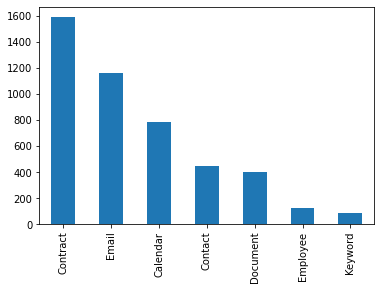

In [12]:
print(utter_data.tags.value_counts())
utter_data.tags.value_counts().plot(kind='bar')

# Observation
It can be seen from the bar graph that the data set is imbalance as the class labes/tags 'contact', 'Document', 'Employee' and 'Keyword' are minor class labels.

In [13]:
utter_data.head()

,question,tags
0,how long is the Human Resources Master Service...,Contract
1,Gfesgh,Keyword
2,List all the events scheduled by jack,Calendar
3,provide statement of works's with CA Europe Sa...,Contract
4,How can we reach Sreejith Nair?,Contact


# Removing duplicate questions
Removing duplicate utter sentence or questions as redundant questions with similar tags won't add any value to the analysis

In [14]:
final_utter=utter_data.drop_duplicates(subset={"question", "tags"}, keep='first', inplace=False)
final_utter.shape

(4441, 2)

Contract    1496
Email       1149
Calendar     757
Contact      450
Document     378
Employee     126
Keyword       85
Name: tags, dtype: int64


<AxesSubplot:>

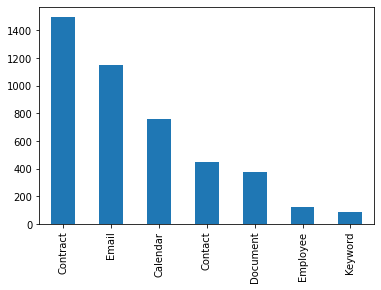

In [15]:
print(final_utter.tags.value_counts())
final_utter.tags.value_counts().plot(kind = 'bar')

In [16]:
#Checking how much data has been retained after removing duplicates from the dataset
(final_utter['tags'].size*1.0)/(utter_data['tags'].size*1.0)*100

96.6064824885795

# Observation
96% of the data is retained after removing the duplicates from the dataset

# Text Preprocessing

In [17]:
# creating a stopword list
stopwords_list = set(stopwords.words('english'))

In [18]:
# Created a mehod which will take a sentnce as an input and return sentence with decontracted form of the contracted words
def expand_Sent(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

In [19]:
#Text cleaning by replacing unwanted words like special charater, html tags, non text character from the senteces 
# Performing stopwords removel, Tokenization, stemming and lemmatization on the text
nltk.download('words')
nltk.download('wordnet')
words = nltk.corpus.words.words() + list(nltk.corpus.wordnet.words())
word_list = set(words)
def text_preprocessing(text, stem_flag=False, lem_flag=True, stopword_list=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r"http\S+", "", text)
    text = bs(text, 'lxml').get_text()
    text = expand_Sent(text)
    text = re.sub("\S*\d\S*", "", text).strip()
    text = re.sub('[^A-Za-z]+', ' ', text)
    ## Tokenizing the string to list of tokens/words
    lst_text = text.split()
    ## removal of Stopwords
    if stopword_list is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords_list]
   # lst_text = [word for word in lst_text if word in word_list or not word.isalpha()]
                
    ## Stemming to convert a word to its base word
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\320035677\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\320035677\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
#Applying test_preprocessing method on the questions and storing back cleaned question column in data frame
#tqdm is for printing the status bar
from tqdm import tqdm
tqdm.pandas()
final_utter["clean_questions"] = final_utter.question.progress_apply(lambda x: 
          text_preprocessing(x, stem_flag=False, lem_flag=True, 
          stopword_list=stopwords_list))
final_utter.head()
len(final_utter)

100%|████████████████████████████████████████████████████████████████████████████| 4441/4441 [00:03<00:00, 1369.93it/s]


4441

In [21]:
#Removing Named Entities
import spacy
nlp = spacy.load('en_core_web_sm')
def removeNamedEntities(sent):

    document = nlp(sent)

    text_without_entities = []

    entities = [ent.text for ent in document.ents]
    for item in document:
        if item.text in entities:
            pass
        else:
            text_without_entities.append(item.text)
    return " ".join(text_without_entities)

In [22]:
from tqdm import tqdm
tqdm.pandas()
final_utter["clean_questions"] = final_utter.clean_questions.progress_apply(lambda x: removeNamedEntities(x))
final_utter.head()
len(final_utter)

100%|██████████████████████████████████████████████████████████████████████████████| 4441/4441 [00:46<00:00, 94.60it/s]


4441

In [23]:
# Replacing empty questions with NaN values
final_utter.clean_questions.replace('', np.nan, inplace=True)
print(final_utter.clean_questions.isna().sum())
final_utter.shape

19


(4441, 3)

There are 19 NaN values in data set

In [24]:
#Droping the questions having NaN values
final_utter.dropna(subset=['clean_questions'], inplace=True)
final_utter.shape

(4422, 3)

# Top three features

In [25]:
#method to see top 3 features in particular row
#change index in tfidf[0,:] in line  number 12 to get tog three features in different rows
tfidfvectorizer = TfidfVectorizer()
tfidf = tfidfvectorizer.fit_transform(final_utter.clean_questions)
features = tfidfvectorizer.get_feature_names()
def top_tfidf_features(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
top_features = top_tfidf_features(tfidf[70,:].toarray()[0],features, 3)
print(top_features)

   feature     tfidf
0  johnson  0.633978
1    kevin  0.628174
2     last  0.324147


# Train and Test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(final_utter.clean_questions, final_utter.tags, test_size=0.3, shuffle=True, random_state = 42)
#final_utter_X_train, final_utter_X_test, final_utter_Y_train, final_utter_Y_test= train_test_split(final_utter.question, final_utter.tags, test_size=0.7, random_state=8, stratify=final_utter.tags)
X_train.head(-5)

3817      akamai technology international ag office found
4416               find last latest statement work skytap
617                                             say bonus
3219                              many mail marked unread
1637                           last receive email netflix
                              ...                        
777                   show meeting scheduled mitchell may
1713    find last latest data processing agreement del...
130                                   organized event soc
2996    termination effective date kloudone inc agreement
3262    represented limited ta sap solution sow eleks inc
Name: clean_questions, Length: 3090, dtype: object

Contract    1034
Email        807
Calendar     547
Contact      304
Document     260
Employee      88
Keyword       55
Name: tags, dtype: int64

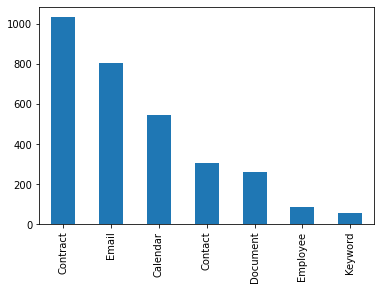

In [27]:
y_train.value_counts().plot(kind='bar')
y_train.value_counts()

Contract    462
Email       342
Calendar    210
Contact     139
Document    112
Employee     38
Keyword      24
Name: tags, dtype: int64

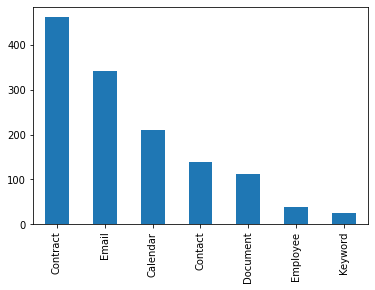

In [28]:
y_test.value_counts().plot(kind='bar')
y_test.value_counts()

# Observation
Both train and test data are imbalanced

# Handling Imbalance Data using SMOTE
SMOTE(SyntheticMinorityOversamplingTechnique) — upsampling:-

It works based on the KNearestNeighbours algorithm, synthetically generating data points that fall in the proximity of the 

already existing outnumbered group. The input records should not contain any null values when applying this approach.

In [25]:
#Perfomr SMOTE oversampling technique
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(y_train)
y_train_transformed = labelEncoder.transform(y_train)
#Converting text data to vetor
tfidfVectorizer = TfidfVectorizer()
tfidf = tfidfVectorizer.fit_transform(X_train)
oversample = SMOTE()
X_train_bal, y_train_bal = oversample.fit_resample(tfidf, y_train_transformed)
print("Imbalance Training set shape:- ")
print(X_train.shape)
print("Balance Training set shape:- ")
print(X_train_bal.shape)

Imbalance Training set shape:- 
(3095,)
Balance Training set shape:- 
(7259, 1531)


In [26]:
y_train_bal  = labelEncoder.inverse_transform(y_train_bal)

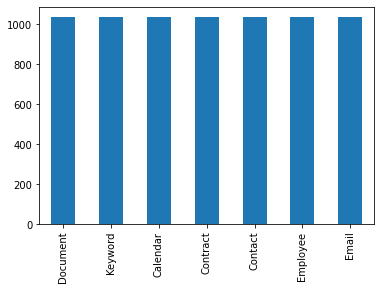

In [27]:
#Checking the size of all labels after SMOTE upsampling 
pd.Series(y_train_bal).value_counts().plot(kind='bar')
y_train_bal = labelEncoder.transform(y_train_bal)

# Observation
After appying Random Oversampler it can be seen that the data is now well balanced, and now can go ahead with the precdiction

# Word2Vec to convert each word to vector
The problem with BoW and tf-idf is they does not retain semantic meaning of the docs or words, where w2vec able to retain semantic meaning of the words or docs which helps in putting similar words near by to each other

In [28]:
class UtterSentences(object):
    """UtterSentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_utter_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('{} already exist. Training w2vec not required.'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not exist. Building new w2vec model......'.format(location))
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
    print('w2vec model training done. Saving to disk')
    model.save(location)
    return model

In [29]:
#Creating word2vec model and saving it is the same location this jnotebook exist
w2vec = get_utter_word2vec(
    UtterSentences(
        final_utter.question.values
    ),
    'w2vmodel'
)

w2vmodel already exist. Training w2vec not required.


# MeanEmbeddingVectorizer (Avg w2v)
Here I'm creating Mean Embedding Vectorizer which is nothing but of Average w2v where we sum up all the w2v of each word in 

a document and divide it by total no. of words in that documnet

Ex:- for document D1 contains words w1,w2,w3 the vector V1  is [w2v(w1)+w2v(w2)+w2v(w3)]/total no. of words in D1

In [30]:
class Tokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = word2vec.wv.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = Tokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

# Tfidf Embedding Vectorizor (Tf-Idf weighted word2vector)
Here, In a document Di each word wi word2vec(wi) multiplied by tfidf of that word wi and sum across

Ex:- In document D1 wrds w1,w2,w3 tfidf weighted vector is :-

tfidf_w2v(D1) = [tfidf1*w2v(w1) + tfidf2*w2v(w2) + tfidf3*w2v(w3)]/sum(tfidf1+tfidf2+tfidf3)

In [31]:
from collections import defaultdict
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = word2vec.wv.vector_size
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        X = Tokenizer().fit_transform(X)
        return np.array([
                np.mean([self.word2vec.wv[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    def fit_transform(self, X, y=None):
        return self.transform(X)

# Predictions
# Logistic regrssion with Bag of words text to vector conversion

In [242]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('ro', SMOTE(random_state=42)),
   ('mnb', LogisticRegression())
])

In [243]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('ro', SMOTE(random_state=42)),
                ('mnb', LogisticRegression())])

In [244]:
predictions_train = textclassifier.predict(X_train)

In [245]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.97      0.98      0.98       535
     Contact       0.97      0.89      0.92       331
    Contract       0.98      1.00      0.99      1022
    Document       0.95      0.97      0.96       252
       Email       0.97      0.99      0.98       793
    Employee       1.00      0.99      0.99        92
     Keyword       1.00      0.80      0.89        70

    accuracy                           0.97      3095
   macro avg       0.98      0.94      0.96      3095
weighted avg       0.97      0.97      0.97      3095



In [246]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.93      0.97      0.95       209
     Contact       0.80      0.70      0.75       160
    Contract       0.94      0.99      0.96       428
    Document       0.57      0.80      0.66        80
       Email       0.93      0.93      0.93       344
    Employee       1.00      0.95      0.97        37
     Keyword       0.74      0.25      0.37        69

    accuracy                           0.89      1327
   macro avg       0.84      0.80      0.80      1327
weighted avg       0.89      0.89      0.88      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

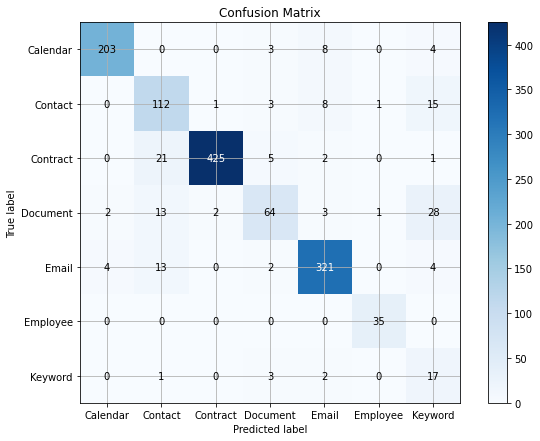

In [247]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Logistic Regression with TF-IDF vector

In [248]:
textclassifier =Pipeline([
  ('vect', TfidfVectorizer()),
   ('ro', SMOTE(random_state=42)),
   ('mnb', LogisticRegression())
])

In [249]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()), ('ro', SMOTE(random_state=42)),
                ('mnb', LogisticRegression())])

In [250]:
predictions_train = textclassifier.predict(X_train)

In [251]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.97      0.98      0.98       533
     Contact       0.97      0.92      0.94       318
    Contract       0.99      1.00      0.99      1029
    Document       0.98      0.95      0.96       266
       Email       0.97      0.98      0.98       799
    Employee       1.00      1.00      1.00        91
     Keyword       1.00      0.95      0.97        59

    accuracy                           0.98      3095
   macro avg       0.98      0.97      0.98      3095
weighted avg       0.98      0.98      0.98      3095



In [252]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.94      0.97      0.95       210
     Contact       0.85      0.77      0.81       154
    Contract       0.96      0.98      0.97       442
    Document       0.79      0.72      0.75       124
       Email       0.94      0.93      0.94       350
    Employee       1.00      0.95      0.97        37
     Keyword       0.13      0.30      0.18        10

    accuracy                           0.91      1327
   macro avg       0.80      0.80      0.80      1327
weighted avg       0.92      0.91      0.91      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

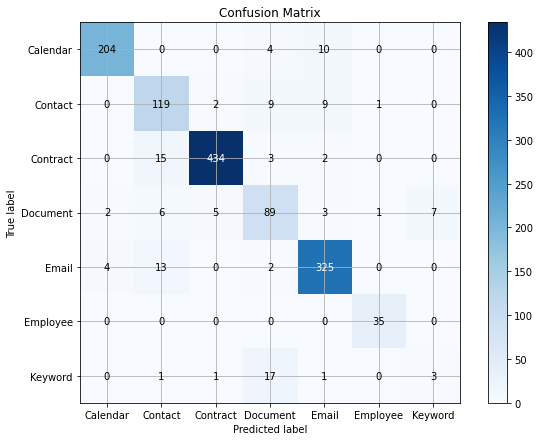

In [253]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Logistic regression with Mean Embedded Vectorizer (Avg w2v)

In [254]:
textclassifier =Pipeline([
    ('w2vec mean vector', MeanEmbeddingVectorizer(w2vec)),
   ('ro', SMOTE(random_state=42)),
   ('mnb', LogisticRegression())
])

In [255]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('w2vec mean vector',
                 <__main__.MeanEmbeddingVectorizer object at 0x000001DD020D8430>),
                ('ro', SMOTE(random_state=42)), ('mnb', LogisticRegression())])

In [256]:
prediction_train = textclassifier.predict(X_train)

In [257]:
print(classification_report(prediction_train,y_train))

              precision    recall  f1-score   support

    Calendar       0.67      0.89      0.76       407
     Contact       0.56      0.42      0.48       405
    Contract       0.80      0.95      0.87       876
    Document       0.30      0.28      0.29       283
       Email       0.78      0.88      0.82       713
    Employee       0.96      0.40      0.56       219
     Keyword       0.84      0.24      0.38       192

    accuracy                           0.71      3095
   macro avg       0.70      0.58      0.59      3095
weighted avg       0.71      0.71      0.69      3095



In [258]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.69      0.89      0.78       170
     Contact       0.59      0.42      0.49       193
    Contract       0.78      0.97      0.86       365
    Document       0.27      0.28      0.27       109
       Email       0.80      0.88      0.84       312
    Employee       0.97      0.37      0.53        93
     Keyword       0.70      0.19      0.30        85

    accuracy                           0.71      1327
   macro avg       0.68      0.57      0.58      1327
weighted avg       0.71      0.71      0.69      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

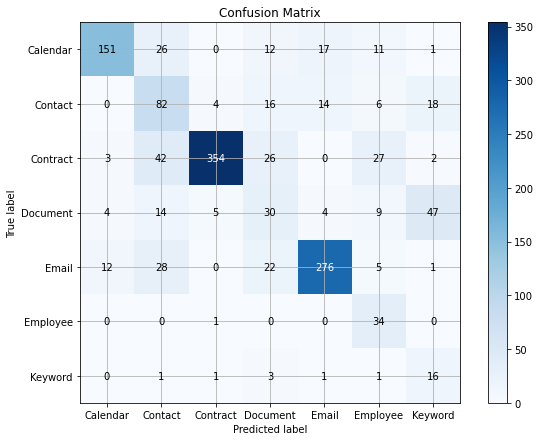

In [259]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Logistic Regression with Tfidf Embedded vectorizer (Tfidf weighted w2vec)

In [260]:
textclassifier =Pipeline([
    ('w2vec mean vector', TfidfEmbeddingVectorizer(w2vec).fit(X_train,None)),
   ('ro', SMOTE(random_state=42)),
   ('mnb', LogisticRegression())
])

In [261]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('w2vec mean vector',
                 <__main__.TfidfEmbeddingVectorizer object at 0x000001DD04C84EE0>),
                ('ro', SMOTE(random_state=42)), ('mnb', LogisticRegression())])

In [262]:
prediction_train = textclassifier.predict(X_train)

In [263]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.97      0.98      0.98       533
     Contact       0.97      0.92      0.94       318
    Contract       0.99      1.00      0.99      1029
    Document       0.98      0.95      0.96       266
       Email       0.97      0.98      0.98       799
    Employee       1.00      1.00      1.00        91
     Keyword       1.00      0.95      0.97        59

    accuracy                           0.98      3095
   macro avg       0.98      0.97      0.98      3095
weighted avg       0.98      0.98      0.98      3095



In [264]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.78      0.89      0.83       193
     Contact       0.59      0.58      0.59       142
    Contract       0.82      0.97      0.89       385
    Document       0.33      0.28      0.30       131
       Email       0.84      0.88      0.86       328
    Employee       0.91      0.48      0.63        67
     Keyword       0.70      0.20      0.31        81

    accuracy                           0.75      1327
   macro avg       0.71      0.61      0.63      1327
weighted avg       0.74      0.75      0.73      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

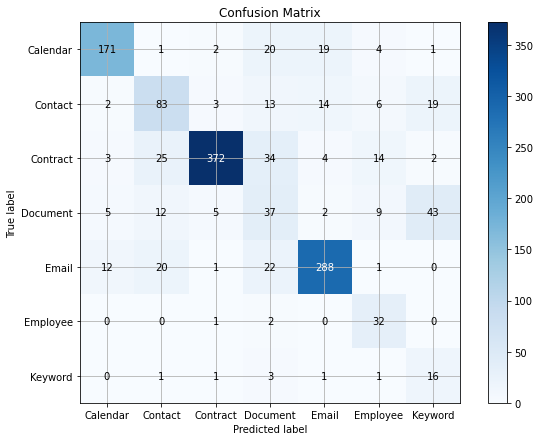

In [265]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# RandomForest Classifier with BoW vector


In [266]:
textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('ro', SMOTE(random_state=42)),
   ('mnb', RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1, n_jobs=-1))
])

In [267]:
textclassifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


Pipeline(steps=[('vect', CountVectorizer()), ('ro', SMOTE(random_state=42)),
                ('mnb',
                 RandomForestClassifier(max_depth=5, n_estimators=1000,
                                        n_jobs=-1, verbose=1))])

In [268]:
predictions_train = textclassifier.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [269]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.87      0.88      0.87       533
     Contact       0.57      0.71      0.64       245
    Contract       0.89      0.97      0.93       950
    Document       0.29      0.96      0.45        78
       Email       0.78      0.94      0.85       671
    Employee       1.00      0.91      0.95       100
     Keyword       0.98      0.11      0.19       518

    accuracy                           0.78      3095
   macro avg       0.77      0.78      0.70      3095
weighted avg       0.84      0.78      0.74      3095



In [270]:
predictions_test = textclassifier.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.7s finished


              precision    recall  f1-score   support

    Calendar       0.88      0.86      0.87       224
     Contact       0.50      0.62      0.56       112
    Contract       0.89      0.97      0.93       414
    Document       0.11      0.86      0.19        14
       Email       0.77      0.92      0.84       289
    Employee       1.00      0.78      0.88        45
     Keyword       0.78      0.08      0.14       229

    accuracy                           0.75      1327
   macro avg       0.70      0.73      0.63      1327
weighted avg       0.81      0.75      0.72      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

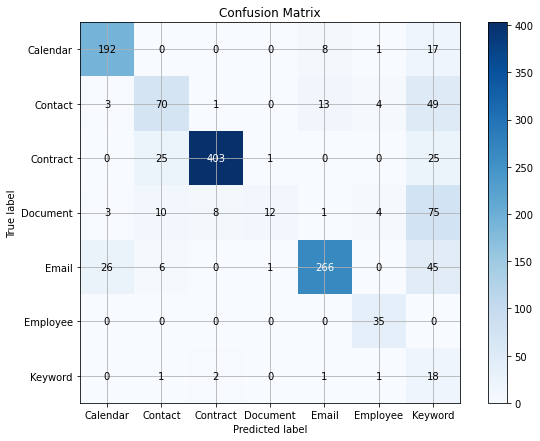

In [271]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Random Forest Classifier with TF-IDF vector

In [272]:
textclassifier =Pipeline([
  ('vect', TfidfVectorizer()),
   ('ro', SMOTE(random_state=42)),
   ('mnb', RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1, n_jobs=-1))
])

In [273]:
textclassifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


Pipeline(steps=[('vect', TfidfVectorizer()), ('ro', SMOTE(random_state=42)),
                ('mnb',
                 RandomForestClassifier(max_depth=5, n_estimators=1000,
                                        n_jobs=-1, verbose=1))])

In [274]:
predictions_train = textclassifier.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [275]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.86      0.93      0.89       496
     Contact       0.67      0.69      0.68       295
    Contract       0.84      0.98      0.90       895
    Document       0.85      0.36      0.51       608
       Email       0.80      0.93      0.86       691
    Employee       1.00      0.96      0.98        95
     Keyword       0.25      0.93      0.39        15

    accuracy                           0.81      3095
   macro avg       0.75      0.83      0.75      3095
weighted avg       0.82      0.81      0.79      3095



In [276]:
predictions_test = textclassifier.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.6s finished


              precision    recall  f1-score   support

    Calendar       0.84      0.91      0.87       203
     Contact       0.60      0.63      0.62       133
    Contract       0.85      0.98      0.91       393
    Document       0.80      0.36      0.50       250
       Email       0.80      0.91      0.85       303
    Employee       1.00      0.88      0.93        40
     Keyword       0.09      0.40      0.14         5

    accuracy                           0.80      1327
   macro avg       0.71      0.72      0.69      1327
weighted avg       0.80      0.80      0.78      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

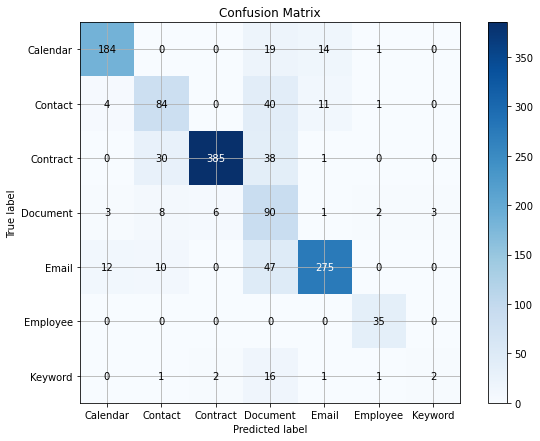

In [277]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Random Forest with Mean Embedded Vectorizer (Avg w2vec)

In [278]:
textclassifier =Pipeline([
  ('vect', MeanEmbeddingVectorizer(w2vec)),
    ('trans', TfidfTransformer()),
   ('ro', SMOTE(random_state=12)),
   ('mnb', RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1, n_jobs=-1))
])

In [279]:
textclassifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished


Pipeline(steps=[('vect',
                 <__main__.MeanEmbeddingVectorizer object at 0x000001DD05493850>),
                ('trans', TfidfTransformer()), ('ro', SMOTE(random_state=12)),
                ('mnb',
                 RandomForestClassifier(max_depth=5, n_estimators=1000,
                                        n_jobs=-1, verbose=1))])

In [280]:
predictions_train = textclassifier.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.7s finished


In [281]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.78      0.89      0.83       473
     Contact       0.75      0.48      0.58       477
    Contract       0.87      0.97      0.91       934
    Document       0.30      0.90      0.45        86
       Email       0.88      0.89      0.89       795
    Employee       1.00      0.53      0.69       172
     Keyword       0.86      0.30      0.45       158

    accuracy                           0.80      3095
   macro avg       0.78      0.71      0.69      3095
weighted avg       0.83      0.80      0.79      3095



In [282]:
predictions_test = textclassifier.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.7s finished


              precision    recall  f1-score   support

    Calendar       0.78      0.86      0.82       197
     Contact       0.70      0.46      0.56       211
    Contract       0.85      0.96      0.90       401
    Document       0.15      0.74      0.25        23
       Email       0.87      0.85      0.86       350
    Employee       1.00      0.48      0.65        73
     Keyword       0.70      0.22      0.34        72

    accuracy                           0.77      1327
   macro avg       0.72      0.65      0.62      1327
weighted avg       0.81      0.77      0.77      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

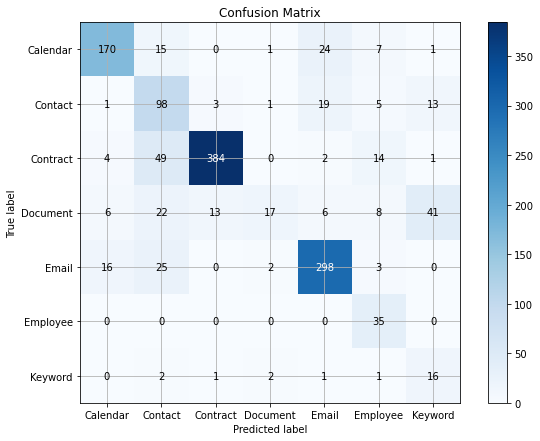

In [283]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Random Forest with Tfidf Embedded Vectorizer (Tfidf weighted w2vec)

In [284]:
textclassifier =Pipeline([
  ('vect', TfidfEmbeddingVectorizer(w2vec).fit(X_train, None)),
    ('trans', TfidfTransformer()),
   ('ro', SMOTE(random_state=12)),
   ('mnb', RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1, n_jobs=-1))
])

In [285]:
textclassifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.8s finished


Pipeline(steps=[('vect',
                 <__main__.TfidfEmbeddingVectorizer object at 0x000001DD05478850>),
                ('trans', TfidfTransformer()), ('ro', SMOTE(random_state=12)),
                ('mnb',
                 RandomForestClassifier(max_depth=5, n_estimators=1000,
                                        n_jobs=-1, verbose=1))])

In [286]:
predictions_train = textclassifier.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [287]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.78      0.89      0.83       474
     Contact       0.74      0.47      0.58       479
    Contract       0.85      0.97      0.91       910
    Document       0.32      0.90      0.47        91
       Email       0.88      0.88      0.88       800
    Employee       1.00      0.50      0.66       183
     Keyword       0.86      0.30      0.45       158

    accuracy                           0.79      3095
   macro avg       0.77      0.70      0.68      3095
weighted avg       0.82      0.79      0.79      3095



In [288]:
predictions_test = textclassifier.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.7s finished


              precision    recall  f1-score   support

    Calendar       0.78      0.86      0.82       198
     Contact       0.69      0.45      0.54       216
    Contract       0.83      0.96      0.89       396
    Document       0.15      0.81      0.25        21
       Email       0.86      0.85      0.86       350
    Employee       1.00      0.47      0.64        74
     Keyword       0.70      0.22      0.34        72

    accuracy                           0.76      1327
   macro avg       0.72      0.66      0.62      1327
weighted avg       0.80      0.76      0.76      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

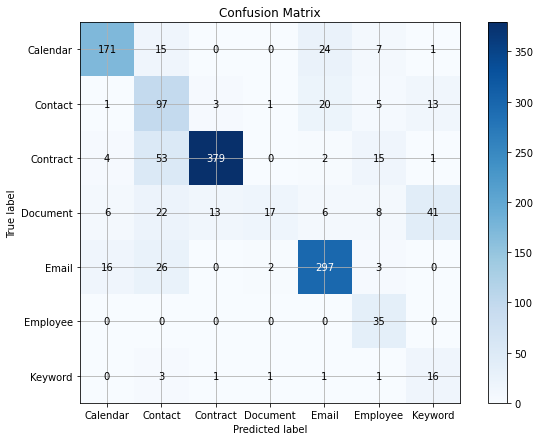

In [289]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# SVM with BoW vector

In [290]:
textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('ro', SMOTE(random_state=42)),
   ('mnb', SVC(kernel='linear', probability=True))
])

In [291]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('ro', SMOTE(random_state=42)),
                ('mnb', SVC(kernel='linear', probability=True))])

In [292]:
predictions_train = textclassifier.predict(X_train)

In [293]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.99      0.99      0.99       539
     Contact       0.98      0.91      0.95       325
    Contract       0.99      1.00      0.99      1029
    Document       0.97      1.00      0.98       253
       Email       0.98      0.99      0.99       799
    Employee       1.00      1.00      1.00        91
     Keyword       1.00      0.95      0.97        59

    accuracy                           0.99      3095
   macro avg       0.99      0.98      0.98      3095
weighted avg       0.99      0.99      0.99      3095



In [294]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.93      0.96      0.95       211
     Contact       0.84      0.72      0.77       163
    Contract       0.96      1.00      0.98       435
    Document       0.40      0.90      0.55        50
       Email       0.93      0.94      0.94       342
    Employee       1.00      0.97      0.99        36
     Keyword       0.74      0.19      0.30        90

    accuracy                           0.88      1327
   macro avg       0.83      0.81      0.78      1327
weighted avg       0.90      0.88      0.87      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

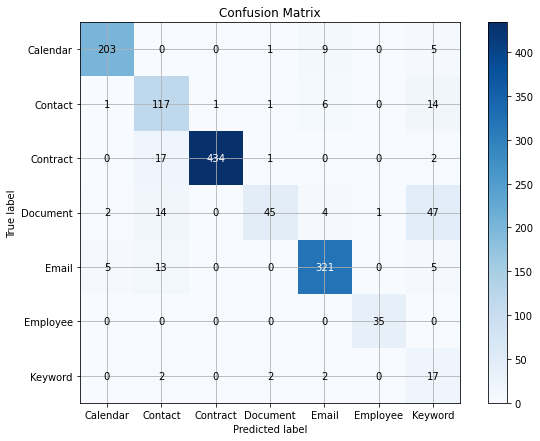

In [295]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# SVM with TF-IDF

In [296]:
textclassifier =Pipeline([
  ('vect', TfidfVectorizer()),
   ('ro', SMOTE(random_state=12)),
   ('mnb', SVC(kernel='linear', probability=True))
])

In [297]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()), ('ro', SMOTE(random_state=12)),
                ('mnb', SVC(kernel='linear', probability=True))])

In [298]:
predictions_train = textclassifier.predict(X_train)

In [299]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.99      0.99      0.99       536
     Contact       0.99      0.92      0.95       324
    Contract       0.99      1.00      1.00      1036
    Document       0.98      0.99      0.98       257
       Email       0.97      0.99      0.98       790
    Employee       1.00      1.00      1.00        91
     Keyword       1.00      0.92      0.96        61

    accuracy                           0.98      3095
   macro avg       0.99      0.97      0.98      3095
weighted avg       0.98      0.98      0.98      3095



In [300]:
predictions_test = textclassifier.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.93      0.98      0.95       208
     Contact       0.88      0.83      0.85       148
    Contract       0.98      0.98      0.98       456
    Document       0.76      0.77      0.76       112
       Email       0.95      0.92      0.94       356
    Employee       1.00      0.97      0.99        36
     Keyword       0.13      0.27      0.18        11

    accuracy                           0.92      1327
   macro avg       0.81      0.82      0.81      1327
weighted avg       0.93      0.92      0.93      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

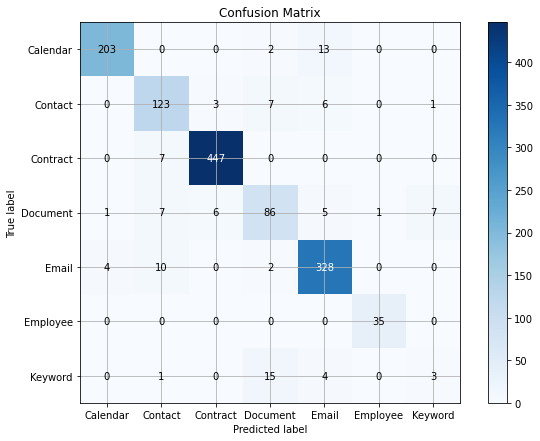

In [301]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# SVM with Mean Embedded Vector

In [302]:
textclassifier_svm =Pipeline([
  ('vect', MeanEmbeddingVectorizer(w2vec)),
   ('ro', SMOTE(random_state=42)),
   ('mnb', SVC(kernel='linear', probability=True))
])

In [303]:
textclassifier_svm.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 <__main__.MeanEmbeddingVectorizer object at 0x000001DD05A26CD0>),
                ('ro', SMOTE(random_state=42)),
                ('mnb', SVC(kernel='linear', probability=True))])

In [304]:
predictions_train = textclassifier_svm.predict(X_train)

In [305]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.63      0.88      0.74       385
     Contact       0.63      0.34      0.44       551
    Contract       0.77      0.97      0.86       830
    Document       0.25      0.29      0.27       228
       Email       0.74      0.88      0.80       680
    Employee       0.96      0.40      0.56       220
     Keyword       0.86      0.24      0.37       201

    accuracy                           0.69      3095
   macro avg       0.69      0.57      0.58      3095
weighted avg       0.70      0.69      0.66      3095



In [306]:
predictions_test = textclassifier_svm.predict(X_test)

              precision    recall  f1-score   support

    Calendar       0.66      0.89      0.76       160
     Contact       0.61      0.36      0.45       239
    Contract       0.76      0.97      0.85       354
    Document       0.25      0.31      0.28        90
       Email       0.76      0.89      0.82       295
    Employee       0.97      0.35      0.52        96
     Keyword       0.70      0.17      0.28        93

    accuracy                           0.69      1327
   macro avg       0.67      0.56      0.57      1327
weighted avg       0.70      0.69      0.66      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

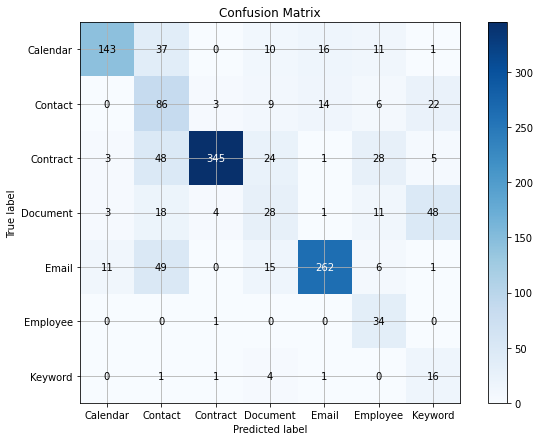

In [307]:
print(classification_report(predictions_test, y_test))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# SVM with Tfidf Embedded Vectorizer

In [308]:
textclassifier =Pipeline([
  ('vect', TfidfEmbeddingVectorizer(w2vec).fit(X_train,None)),
   ('ro', SMOTE(random_state=12)),
   ('mnb', SVC(kernel='linear', probability=True))
])

In [309]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 <__main__.TfidfEmbeddingVectorizer object at 0x000001DD05ABE580>),
                ('ro', SMOTE(random_state=12)),
                ('mnb', SVC(kernel='linear', probability=True))])

In [310]:
predictions_train = textclassifier.predict(X_train)

In [311]:
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

    Calendar       0.84      0.89      0.87       508
     Contact       0.79      0.65      0.71       372
    Contract       0.89      0.97      0.93       955
    Document       0.43      0.53      0.48       211
       Email       0.85      0.92      0.88       749
    Employee       0.97      0.75      0.85       117
     Keyword       0.93      0.28      0.44       183

    accuracy                           0.83      3095
   macro avg       0.81      0.71      0.74      3095
weighted avg       0.83      0.83      0.82      3095



In [312]:
predictions_test = textclassifier.predict(X_test)


              precision    recall  f1-score   support

    Calendar       0.85      0.86      0.85       215
     Contact       0.68      0.58      0.62       164
    Contract       0.85      0.98      0.91       395
    Document       0.36      0.47      0.41        87
       Email       0.87      0.90      0.88       332
    Employee       0.94      0.67      0.79        49
     Keyword       0.74      0.20      0.31        85

    accuracy                           0.80      1327
   macro avg       0.76      0.67      0.68      1327
weighted avg       0.80      0.80      0.78      1327



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

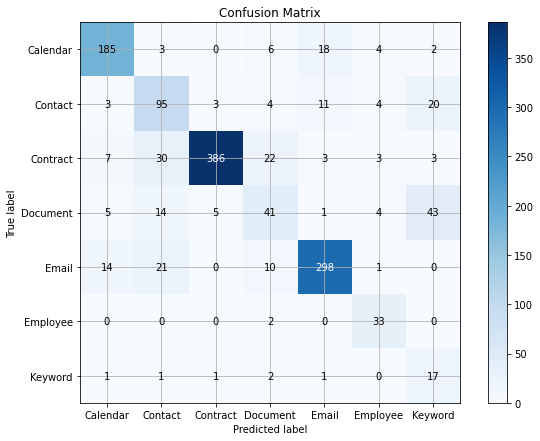

In [313]:
import matplotlib.pyplot as plt
print(classification_report(predictions_test, y_test))
#print(classification_report(prediction_instance, ))
skplt.plot_confusion_matrix(y_test, predictions_test,figsize=(10,7))

# Observations

Below table presents the train and test accuracy of all the classifiers with ther vector representation

| Classifier | vector representation | Train Accuracy | Test Accuracy
| :- | -: | :-: | :-: |
| Logistic Rgression| BoW | 0.98 | 0.92
|                   | TF-IDF | 0.98 | 0.92
|                   | Mean Embedded w2v | 0.72 | 0.72
|                   | Tfidf Embedded w2v | 0.98 | 0.75
| Random Forest     | BoW | 0.79 | 77
|                   | TF-IDF | 0.82 | 0.80
|                   | Mean Embedded w2v | 0.80 | 0.79
|                   | Tfidf Embedded w2v | 0.81 |0.78
| SVM               | BoW | 0.99 | 0.91
|                   | TF-TDF | 0.99 | 0.93
|                   | Mean Embedded w2v | 0.72 | 0.70
|                   | Tfidf Embedded w2v | 0.82 | 0.79

1) It can be observe that both LR and SVM performs well with Bow and TF-TDF vector representation

2) Wheareas RF seems to be good choice if Mean embedded and Tfidf Ebedded vectorize represention is used to pass to the model, as it ourperforms both LR and SVM 

3) SVM also performs well with Tfidf vecotrize representaion

# LSTM Model

# Text Preprocessing required for LSTM

In [29]:
# The maximum number of words to be used. (most frequent)
TOTAL_NOS_WORDS = 4000
# Max number of words in each complaint.
MAX_LENGTH_SEQUENCE = 141
# This is fixed.
EMBEDDING_DIMENSION = 100
X_train_length = X_train.apply(len)
X_train_length.max()
count = X_train.str.split().apply(len).value_counts()
print(count.sum())
tokenizer = keras.preprocessing.text.Tokenizer(num_words=TOTAL_NOS_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

3095
Found 1538 unique tokens.


In [30]:
#Preprocessing for test data
Tcount = X_test.str.split().apply(len).value_counts()
tokenizer = keras.preprocessing.text.Tokenizer(num_words=TOTAL_NOS_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_test.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1044 unique tokens.


In [31]:
#Preprocessing on test set
from tensorflow.keras import preprocessing
X_test_vec = tokenizer.texts_to_sequences(X_test.values)
X_test_vec = preprocessing.sequence.pad_sequences(X_test_vec, maxlen=MAX_LENGTH_SEQUENCE)
print('Shape of data tensor:', X_test_vec.shape)

Shape of data tensor: (1327, 141)


In [32]:
#Vectorizing training data
from tensorflow.keras import preprocessing as prep
X = tokenizer.texts_to_sequences(X_train.values)
X = prep.sequence.pad_sequences(X, maxlen=MAX_LENGTH_SEQUENCE)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3095, 141)


In [33]:
#Performing SMOTE Oversampling on train data
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(y_train)
y_train_transformed = labelEncoder.transform(y_train)
oversample = SMOTE()
X_train_bal, y_train_bal = oversample.fit_resample(X, y_train_transformed)
print("Imbalance Training set shape:- ")
print(X_train.shape)
print("Balance Training set shape:- ")
print(X_train_bal.shape)
print(type(X_train_bal))

Imbalance Training set shape:- 
(3095,)
Balance Training set shape:- 
(7238, 141)
<class 'numpy.ndarray'>


In [36]:
#Performing smote on testing data
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(y_test)
y_test_transformed = labelEncoder.transform(y_test)
oversample = RandomOverSampler()
X_test_bal, y_test_bal = oversample.fit_resample(X_test_vec, y_test_transformed)
print("Imbalance Training set shape:- ")
print(X_test.shape)
print("Balance Training set shape:- ")
print(X_test_bal.shape)
print(type(X_test_bal))

Imbalance Training set shape:- 
(1327,)
Balance Training set shape:- 
(3234, 141)
<class 'numpy.ndarray'>


In [37]:
#As shape of y_train_bal should be 7245*7 i.4 7245 components and 7 is no. of classes but here it is (7245,) improper, 
#using keras.utils.to_categorical to correct the shape
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
Y_train_bal_new = pd.get_dummies(y_train_bal).values
print('Shape of label tensor:', Y_train_bal_new.shape)
print(type(Y_train_bal_new))

Shape of label tensor: (7238, 7)
<class 'numpy.ndarray'>


In [38]:
#By Default hidden activationunit is tanh
from tensorflow.keras import Sequential
model = Sequential()
model.add(layers.Embedding(TOTAL_NOS_WORDS, EMBEDDING_DIMENSION, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train_bal, Y_train_bal_new, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
102/102 [==============================] - 89s 825ms/step - loss: 1.4829 - accuracy: 0.4734 - val_loss: 2.3581 - val_accuracy: 0.0000e+00
Epoch 2/5
102/102 [==============================] - 82s 809ms/step - loss: 0.7618 - accuracy: 0.7310 - val_loss: 1.5626 - val_accuracy: 0.0000e+00
Epoch 3/5
102/102 [==============================] - 84s 826ms/step - loss: 0.5843 - accuracy: 0.7934 - val_loss: 1.2006 - val_accuracy: 0.6575
Epoch 4/5
102/102 [==============================] - 86s 841ms/step - loss: 0.5071 - accuracy: 0.8144 - val_loss: 1.3077 - val_accuracy: 0.6575
Epoch 5/5
102/102 [==============================] - 89s 869ms/step - loss: 0.4478 - accuracy: 0.8411 - val_loss: 1.2657 - val_accuracy: 0.6906


In [39]:
Y_test_encoded = pd.get_dummies(y_test_bal).values
accr = model.evaluate(X_test_bal,Y_test_encoded)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

102/102 [==============================] - 7s 68ms/step - loss: 0.5543 - accuracy: 0.7761
Test set
  Loss: 0.554
  Accuracy: 0.776


# Observation
1) Train Accuracy is 83.7 % and Validation acuracy is 63.5%

2) Test Accuracy is 78.5 %

# Training and Validation loss in LSTM
Comparing the training and validation loss using plot

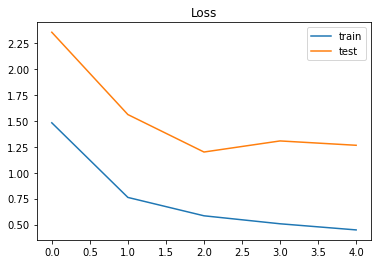

In [45]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
